Computing Reynolds components of DSE tendency

Similar to the DSE tendency notebook

In [1]:
from minio import Minio
import s3fs
import os
import matplotlib.pyplot as plt
import xarray as xr
import pickle
import numpy as np
from sympl import get_constant
import metpy
from metpy.units import units

fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "http://192.168.1.237:9000"
    },
    key="d0d250b2541ac33f4660",
    secret="2fb32d964768bc94a3c0"
)
output_dir='/home/scratch/Abel_data/hw_processed/ctrl/'


Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

In [2]:
# start with the climatology file

climfile=output_dir+'climatology.nc'
ds=xr.open_dataset(climfile)

p1=ds['air_pressure'].fillna(ds['surface_air_pressure'])
at=ds['air_temperature'].fillna(ds['surface_temperature']).copy()
at[1:, :]=(at.values[:-1, :]+at.values[1:, :])/2; at[0, :]=(at[0, :].values[:]+ds['surface_temperature'].values[:])/2
p2=p1.copy()
p2[1:,:]=p1[:-1,:].values[:]
p2[0,:]=ds['surface_air_pressure'].values[:]

lat_rad=np.radians(ds['air_temperature'].lat)

z=(Rd*at/g*np.log(p2/p1)).cumsum(dim='lev')
    
dse_clim=Cp*ds['air_temperature']+g*z
u_clim=ds['eastward_wind']; v_clim=ds['northward_wind']; w_clim=ds['vertical_wind']

def avg_cons(x):
    return (x.values[1:]+x.values[:-1])/2

def diff_cons(x):
    return (x.values[1:]-x.values[:-1])

def compute_dse(ds, latc, lonc):
    # computes average DSE in the box between specified levels - units of J/kg
    
    p1=ds['air_pressure'].fillna(ds['surface_air_pressure'])
    at=ds['air_temperature'].fillna(ds['surface_temperature']).copy()
    at[:,1:]=(at.values[:,:-1]+at.values[:,1:])/2; at[:,0]=(at[:,0].values[:]+ds['surface_temperature'].values[:])/2
    p2=p1.copy()
    p2[:,1:]=p1[:,:-1].values[:]
    p2[:,0]=ds['surface_air_pressure'].values[:]
    
    lat_rad=np.radians(ds['air_temperature'].lat)
    
    z=(Rd*at/g*np.log(p2/p1)).cumsum(dim='lev')
    dse=(Cp*ds['air_temperature']+g*z).sel({'lat':slice(latc+5,latc-5),
                                            'lon':slice(lonc-5,lonc+5),'lev':slice(98000, 90000)}).weighted(np.cos(lat_rad))
    return dse.mean(dim=('lat', 'lon','lev'))

def compute_dse_tend(ds, latc, lonc):
    # computes average DSE tendency Reynolds components in the box between specified levels - units of J/kg
    
    p1=ds['air_pressure'].fillna(ds['surface_air_pressure'])
    at=ds['air_temperature'].fillna(ds['surface_temperature']).copy()
    at[:,1:]=(at.values[:,:-1]+at.values[:,1:])/2; at[:,0]=(at[:,0].values[:]+ds['surface_temperature'].values[:])/2
    p2=p1.copy()
    p2[:,1:]=p1[:,:-1].values[:]
    p2[:,0]=ds['surface_air_pressure'].values[:]
    
    lat_rad=np.radians(ds['air_temperature'].lat)
    
    z=(Rd*at/g*np.log(p2/p1)).cumsum(dim='lev')
    dse=Cp*ds['air_temperature']+g*z
    
    # adding the dse components to a list
    rey_grp=[]
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lev')/units.metre*ds['vertical_wind'])
    rey_grp.append(-metpy.calc.first_derivative(dse-dse_clim, axis='lat')*(ds['northward_wind']-v_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse_clim, axis='lat')*(ds['northward_wind']-v_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse-dse_clim, axis='lat')*(v_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse_clim, axis='lat')*(v_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse-dse_clim, axis='lon')*(ds['eastward_wind']-u_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse_clim, axis='lon')*(ds['eastward_wind']-u_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse-dse_clim, axis='lon')*(u_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse_clim, axis='lon')*(u_clim))
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lon')*ds['eastward_wind']
                   -metpy.calc.first_derivative(dse, axis='lat')*ds['northward_wind']
                   -metpy.calc.first_derivative(dse, axis='lev')/units.metre*ds['vertical_wind'])
    
    
    rey_out=[]
    for e in rey_grp:
        rey_out.append((e).sel({'lat':slice(latc+5,latc-5), 'lon':slice(lonc-5,lonc+5),
                                'lev':slice(98000, 90000)}).weighted(np.cos(lat_rad)).mean(dim=('lat', 'lon','lev'))*86400)
    
    return rey_out
                                                                                                
    
latc=50
output_file=output_dir+'hw_temp_'+str(latc)
with open(output_file, 'rb') as f:
    hw_master=pickle.load(f)
    
hw_index=1

y=1
loop=0
dse_master={'index':[], 'T':[], 'lonc':[], 'dse_low':[], 'intensity':[], 'duration':[], 'maximum':[],
            'dseres':[],'dsez':[],'dsexaa':[],'dsexca':[],'dsexac':[],'dsexcc':[],'dseyaa':[],'dseyca':[],
            'dseyac':[],'dseycc':[], 'dsetot':[]}

# number of heatwaves to process
full_length=50#len(hw_master['index'])
while hw_index<=full_length:
    r=hw_master['run'][hw_index-1]
    zarr_path = "abel-long-run/Regridded_data/run"+str(r)+"/year"+str(y)
    ds = xr.open_zarr(fs.get_mapper(zarr_path))

    while(True):
        time_slice=hw_master['time'][hw_index-1]
        try:
            # set intensity and duration filtering here!
            if hw_master['intensity'][hw_index-1]>np.quantile(hw_master['intensity'], 0):
                ds_hw=ds.sel({'time':time_slice})
                print(hw_index);loop=0

                dse_low=compute_dse(ds_hw, latc, hw_master['lonc'][hw_index-1])
                dse_master['dse_low'].append(dse_low)
                
                dse_tend_low=compute_dse_tend(ds_hw, latc, hw_master['lonc'][hw_index-1])
                
                # appending staggered tendencies to the master dictionary
                # staggered tendencies should match the DSE difference between timesteps
                dse_master['dsez'].append(avg_cons(dse_tend_low[0]))
                dse_master['dseyaa'].append(avg_cons(dse_tend_low[1]))
                dse_master['dseyca'].append(avg_cons(dse_tend_low[2]))
                dse_master['dseyac'].append(avg_cons(dse_tend_low[3]))
                dse_master['dseycc'].append(np.array(dse_tend_low[4].values))
                dse_master['dsexaa'].append(avg_cons(dse_tend_low[5]))
                dse_master['dsexca'].append(avg_cons(dse_tend_low[6]))
                dse_master['dsexac'].append(avg_cons(dse_tend_low[7]))
                dse_master['dsexcc'].append(np.array(dse_tend_low[8].values))
                dse_master['dsetot'].append(avg_cons(dse_tend_low[9]))
                dse_master['dseres'].append(diff_cons(dse_low)-avg_cons(dse_tend_low[9]))

                for e in hw_master.keys():
                    if e in dse_master.keys():
                        dse_master[e].append(hw_master[e][hw_index-1])
            
            hw_index=hw_index+1
            if hw_index>full_length:
                break
        except KeyError:
            loop=loop+1
            if loop>20:
                print('skipping!')
                hw_index=hw_index+1
                loop=0
                break
            if y<20:
                y=y+1
            else:
                y=1
            break
            
# print(dse_master)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


dseyca 8.01911389376945e-15 5.998197785869206e-15
dseyaa -5.0460429851269834e-15 5.963568676208158e-15
dsexac 1.0468044648919359e-15 4.2641266200584025e-15
dsexaa 7.874050478213806e-16 3.044102859478566e-15
dsez -2.0251629616955558e-15 1.3601802325551573e-15
dsetot 2.888707278664581e-15 2.464034068052431e-15
dseres -1.3431547079386742e-15 1.5560865247788847e-15
2.782117459660228e-15


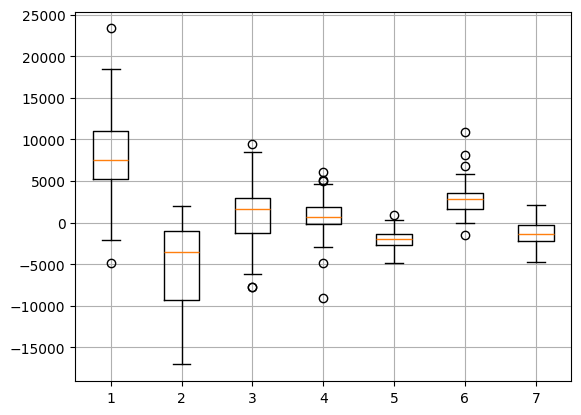

In [3]:
x=[]
chk=[]
for d in ['dseyca','dseyaa','dsexac','dsexaa','dsez','dsetot', 'dseres']:
    chk.append( np.mean([np.mean(np.cumsum(np.insert(e, 0, 0))) for e in dse_master[d]])/1e18)
    x.append(([np.mean(np.cumsum(np.insert(e, 0, 0))) for e in dse_master[d]]))
    print(d, np.mean([np.mean(np.cumsum(np.insert(e, 0, 0))) for e in dse_master[d]])/1e18, np.std([e.cumsum().mean().item() for e in dse_master[d]])/1e18)

plt.boxplot(x)
plt.grid()
print(np.sum(chk[:-2]))

In [15]:
# same as above, but does it for the three directions only

def avg_cons(x):
    return (x.values[1:]+x.values[:-1])/2

def diff_cons(x):
    return (x.values[1:]-x.values[:-1])

def compute_dse(ds, latc, lonc):
    
    p1=ds['air_pressure']
    p2=p1.copy()
    p2[:,1:]=p1[:,:-1].values[:]
    p2[:,0]=ds['surface_air_pressure'].values[:]
    
    lat_rad=np.radians(ds['air_temperature'].lat)
    
    z=(Rd*ds['air_temperature']/g*np.log(p2/p1)).cumsum(dim='lev')
    dse=(Cp*ds['air_temperature']+g*z).sel({'lat':slice(latc+5,latc-5),
                                            'lon':slice(lonc-5,lonc+5),'lev':slice(96000, 84000)}).weighted(np.cos(lat_rad))
    return dse.mean(dim=('lat', 'lon','lev'))

def compute_dse_tend(ds, latc, lonc):
    
    p1=ds['air_pressure'].fillna(ds['surface_air_pressure'])
    at=ds['air_temperature'].fillna(ds['surface_temperature']).copy()
    at[:,1:]=(at.values[:,:-1]+at.values[:,1:])/2; at[:,0]=(at[:,0].values[:]+ds['surface_temperature'].values[:])/2
    p2=p1.copy()
    p2[:,1:]=p1[:,:-1].values[:]
    p2[:,0]=ds['surface_air_pressure'].values[:]
    
    lat_rad=np.radians(ds['air_temperature'].lat)
    
    z=(Rd*at/g*np.log(p2/p1)).cumsum(dim='lev')
    dse=Cp*ds['air_temperature']+g*z
    
    rey_grp=[]
    
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lev')/units.metre*ds['vertical_wind'])
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lat')*ds['northward_wind'])
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lon')*ds['eastward_wind'])
    
    rey_grp.append(-metpy.calc.first_derivative(dse, axis='lon')*(ds['eastward_wind'])
                   -metpy.calc.first_derivative(dse, axis='lat')*(ds['northward_wind'])
                  -metpy.calc.first_derivative(dse, axis='lev')/units.metre*ds['vertical_wind'])
    
    rey_out=[]
    for e in rey_grp:
        rey_out.append((e).sel({'lat':slice(latc+5,latc-5), 'lon':slice(lonc-5,lonc+5),
                                'lev':slice(96000, 84000)}).weighted(np.cos(lat_rad)).mean(dim=('lat', 'lon','lev'))*86400)
    
    return rey_out
                                                                                                
    
latc=50
output_file=output_dir+'hw_temp_'+str(latc)
with open(output_file, 'rb') as f:
    hw_master=pickle.load(f)
    
hw_index=1

y=1
loop=0
dse_master={'index':[], 'T':[], 'lonc':[], 'dse_low':[], 'intensity':[], 'duration':[], 'maximum':[],
            'dseres':[],'dsez':[],'dsex':[],'dsey':[], 'dsetot':[]}


full_length=500#len(hw_master['index'])
while hw_index<=full_length:
    r=hw_master['run'][hw_index-1]
    zarr_path = "abel-long-run/Regridded_data/run"+str(r)+"/year"+str(y)
    ds = xr.open_zarr(fs.get_mapper(zarr_path))

    while(True):
        time_slice=hw_master['time'][hw_index-1]
        try:
            if hw_master['intensity'][hw_index-1]>np.quantile(hw_master['intensity'], 0.9):
                ds_hw=ds.sel({'time':time_slice})
                print(hw_index);loop=0

                dse_low=compute_dse(ds_hw, latc, hw_master['lonc'][hw_index-1])
                dse_master['dse_low'].append(dse_low)
                
                dse_tend_low=compute_dse_tend(ds_hw, latc, hw_master['lonc'][hw_index-1])

                dse_master['dsez'].append(avg_cons(dse_tend_low[0]))
                dse_master['dsey'].append(avg_cons(dse_tend_low[1]))
                dse_master['dsex'].append(avg_cons(dse_tend_low[2]))
                dse_master['dsetot'].append(avg_cons(dse_tend_low[3]))
                dse_master['dseres'].append(diff_cons(dse_low)-avg_cons(dse_tend_low[3]))

                for e in hw_master.keys():
                    if e in dse_master.keys():
                        dse_master[e].append(hw_master[e][hw_index-1])

            hw_index=hw_index+1
            if hw_index>full_length:
                break
        except KeyError:
            loop=loop+1
            if loop>20:
                print('skipping!')
                hw_index=hw_index+1
                loop=0
                break
            if y<20:
                y=y+1
            else:
                y=1
            break
            
# print(dse_master)

24
33
38
53
55
79
80
100
106
108
128
130
151
164
173
175
186
190
200
201
205
213
221
273
277
279
292
293
304
306
307
309
319
335
372
389
391
392
410
412
426
432
445
458
459
461
482
488
491


dsey 6.221281763873649e-15 5.425706266632861e-15
dsex 1.4770288226662993e-15 4.952573571082524e-15
dsez -3.673469328995576e-15 2.4769880690469846e-15
dsetot 4.025928142459064e-15 2.6962144317608914e-15
4.024841257544372e-15


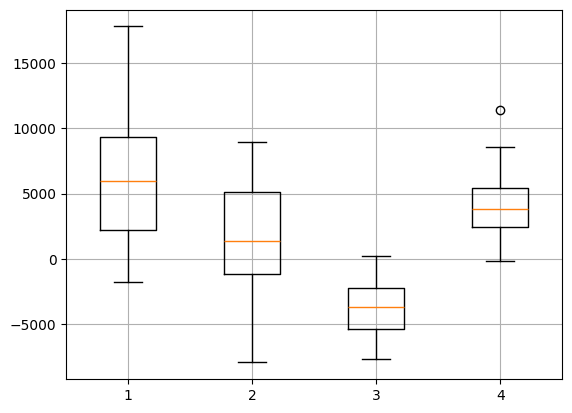

In [16]:
x=[]
chk=[]
for d in ['dsey','dsex','dsez','dsetot']:
    chk.append( np.mean([np.mean(np.cumsum(np.insert(e, 0, 0))) for e in dse_master[d]])/1e18)
    x.append(([np.mean(np.cumsum(np.insert(e, 0, 0))) for e in dse_master[d]]))
    print(d, np.mean([np.mean(np.cumsum(np.insert(e, 0, 0))) for e in dse_master[d]])/1e18, np.std([e.cumsum().mean().item() for e in dse_master[d]])/1e18)

plt.boxplot(x)
plt.grid()
print(np.sum(chk[:-1]))